In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import pandas as pd
import numpy as np
import math 

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)
test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





In [0]:

BATCH_SIZE = 128    
N_EPOCHS = 100       
INPUT_DIM = 784    
HIDDEN_DIM = 512   
LATENT_DIM = 2  
lr = 0.001

In [0]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
class DNAE(nn.Module):
    def __init__(self):
        super(DNAE,self).__init__()
        self.enc1 = nn.Linear(784,512)
        self.enc2 = nn.Linear(512,256)
        self.enc3 = nn.Linear(256,64)

        self.dec1 = nn.Linear(64,256)
        self.dec2 = nn.Linear(256,512)
        self.dec3 = nn.Linear(512, 784)
    
    def forward(self , x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))

        return x

In [0]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # vae
    model = DNAE().to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

In [0]:
def train():
        # set the train mode
        model.train()

        # loss of the epoch
        train_loss = 0

        for i, (images, labels) in enumerate(train_iterator):
            # reshape the data into [batch_size, 784]
            images = images.view(-1, 28 * 28)
            noisy_images = images + torch.randn_like(images)
            noisy_images = np.clip(noisy_images,0.,1.)
            noisy_images = noisy_images.to(device)
            
            # update the gradients to zero
            optimizer.zero_grad()

            # forward pass
            output = model(noisy_images)

            # total loss
            loss = criterion(output,images)

            # backward pass
            loss.backward()
            train_loss += loss.item()
            
            # update the weights
            optimizer.step()

        return train_loss

In [0]:

def test():
        # set the evaluation mode
        model.eval()

        # test loss for the data
        test_loss = 0

        # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
        with torch.no_grad():
            for i, (x, _) in enumerate(test_iterator):
                # reshape the data
                x = x.view(-1, 28 * 28)
                noise = x + torch.randn_like(x)
                noise = np.clip(noise,0.,1.)
                noise = noise.to(device)

                # forward pass
                output = model(noise)

                
                # total loss
                loss = criterion(output,x)
                test_loss += loss.item()

        return test_loss

In [9]:
    best_test_loss = float('inf')
    for e in range(N_EPOCHS):

        train_loss = train()
        test_loss = test()

        train_loss /= len(train_dataset)
        test_loss /= len(test_dataset)

        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

Epoch 0, Train Loss: 0.00, Test Loss: 0.00
Epoch 1, Train Loss: 0.00, Test Loss: 0.00


KeyboardInterrupt: ignored

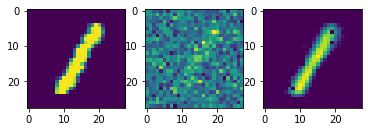

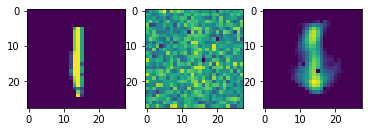

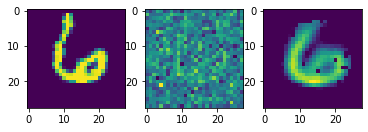

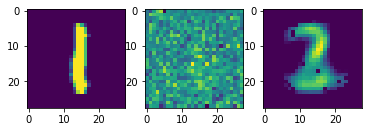

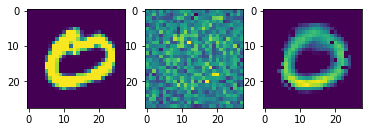

In [37]:

# sample and generate a image
    for i, (images, labels) in enumerate(test_iterator):
      # reshape the data into [batch_size, 784]
      images = images.view(-1, 28 * 28)

    for c in range(5):
      i = images[c]
      xx = i.view(1,28*28)
      xx = xx + torch.randn_like(images[0])

      # run only the decoder
      reconstructed_img = model(xx)
      nimg = xx.view(28,28).data
      img = reconstructed_img.view(28, 28).data
      oimg = i.view(28,28).data
      loss = criterion(img,oimg)

      f, axarr = plt.subplots(1,3)
      axarr[0,].imshow(oimg)
      axarr[1].imshow(nimg)
      axarr[2].imshow(img)